In [1]:
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
import aplpy
from astropy.wcs import WCS
from matplotlib import cm
from astropy.table import Table
from astropy.coordinates import SkyCoord

import pandas as pd
import astropy.units as u
import matplotlib.patheffects as pe


from tqdm import tqdm

In [2]:
# read cube FITS data
filename = "C:\\Users\\alexf\Japan internship\\C18O\\ngc1333TP.C18O.cube.valueK.fits"
species = 'C18O'
hdu = fits.open(filename)[0]
w = WCS(hdu)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [3]:
# confirm data shape and header
print(hdu.data.shape)
print(hdu.header)

(511, 860, 560)
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  560                                                  NAXIS2  =                  860                                                  NAXIS3  =                  511                                                  BMAJ    =   8.268309444444E-03                                                  BMIN    =   8.268309444444E-03                                                  BPA     =   6.475633100000E+01                                                  BTYPE   = 'Intensity'                                                           OBJECT  = 'NGC1333 '                                                            BUNIT   = 'K       '           /Brightness (pixel) unit                         EQUINOX =   2.0000000000

# Load YSO from Gutermuth et al. and convert into photutils pixel aperture

In [4]:
w_no_rad = w.dropaxis(2)
print(w_no_rad)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 52.32135166667  31.45439166667  
CRPIX : 281.0  431.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0008333333333333  0.0008333333333333  
NAXIS : 560  860


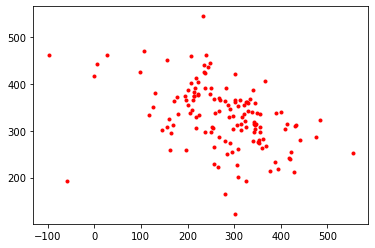

In [5]:
tab_yso = fits.open("gutermuth_YSO")
df_yso = Table(tab_yso[1].data).to_pandas()

yso_ra, yso_dec = df_yso['RAJ2000'], df_yso['DEJ2000']

yso_positions = SkyCoord(yso_ra*u.deg,yso_dec*u.deg)
yso_pixels = w_no_rad.world_to_pixel(yso_positions)
plt.plot(yso_pixels[1],yso_pixels[0],"r.")

In [6]:
def v2ch(v, w): # convert velocity (km/s) to channel 
    x_tempo, y_tempo, v_tempo   = w.wcs_pix2world(0, 0, 0, 0)
    x_ch, y_ch, v_ch   = w.wcs_world2pix(x_tempo, y_tempo, v*1000.0, 0)
    v_ch = int(round(float(v_ch), 0))
    return v_ch

def ch2v(ch, w):#km/s
    x, y, v   = w.wcs_pix2world(0, 0, ch, 0)
    return v/1000.0

def del_header_key(header, keys): # delete header key
    import copy
    h = copy.deepcopy(header)
    for k in keys:
        try:
            del h[k]
        except:
            pass
    return h

def make_new_hdu_integ(hdu, v_start_wcs, v_end_wcs, w): # make header of integrated intensity map
    data = hdu.data
    header = hdu.header
    start_ch, end_ch = v2ch(v_start_wcs, w), v2ch(v_end_wcs, w)
    new_data = np.sum(data[start_ch:end_ch+1], axis=0)*np.abs(header["CDELT3"])/1000.0
    header = del_header_key(header, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3", "PC1_3", "PC2_3", "PC3_3", "PC3_1", "PC3_2"])
    header["NAXIS"] = 2
    new_hdu = fits.PrimaryHDU(new_data, header)
    return new_hdu

def make_new_hdu_integ_ch(hdu, v_start_ch, v_end_ch, w): # make header of integrated intensity map
    data = hdu.data
    header = hdu.header
    new_data = np.sum(data[v_start_ch:v_end_ch], axis=0)*header["CDELT3"]/1000.0
    header = del_header_key(header, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3", "PC1_3", "PC2_3", "PC3_3", "PC3_1", "PC3_2"])
    header["NAXIS"] = 2
    new_hdu = fits.PrimaryHDU(new_data, header)
    return new_hdu

In [7]:
def func_chmap_integ_nxm(fits_name, v_start, ch_range, color_min, color_max, mapcenter_x, mapcenter_y, mapsize_x, mapsize_y, figsize, n, m, cmap, stretch, cb_label, yso = False,image_no=0,desc=""):
    from astropy.io import fits
    from astropy.wcs import WCS
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import aplpy
    from matplotlib.colorbar import ColorbarBase
    #from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.colors import LogNorm
    import math
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    save_name = f"pdf/NGC1333TP.{species}.{desc}_v_{image_no}-1_cube_rms-{v_start}kms-{ch_range}ch" #save name
    hdu = fits.open(fits_name)[0]
    h = hdu.header
    d = hdu.data
    w = WCS(h)
    ch_start = v2ch(v_start, w)
    print(f"ch_s={ch_start}")
    position_addedlabel_x, position_addedlabel_y = mapcenter_x + mapsize_x*-0.25, mapcenter_y + mapsize_y*0.45 # label position, need to change

    fig = plt.figure(figsize=figsize)

    for i in range(n*m):
        ch_start_i, ch_end_i = int(ch_start+i*ch_range), int(ch_start+(i+1)*ch_range)
        v_start, v_end = ch2v(ch_start_i, w), ch2v(ch_end_i-1, w)
        hdu_color = make_new_hdu_integ_ch(hdu, ch_start_i, ch_end_i , w)

        f = aplpy.FITSFigure(hdu_color, slices=[0], figure=fig, subplot=[0.1+(0.8/float(n)*math.floor(i%n)),0.9-(0.8/float(m)*math.floor(i/n+1)), 0.8/float(n), 0.8/float(m)], convention='wells')
        f.recenter(mapcenter_x, mapcenter_y, width=mapsize_x, height=mapsize_y)
        f.show_colorscale(vmin=color_min, vmax=color_max, cmap=cmap, stretch=stretch)
        f.ticks.set_color("k")
        v_start_label, v_end_label = ch2v(ch_start_i, w), ch2v(ch_end_i, w)
        f.add_label(position_addedlabel_x, position_addedlabel_y, "%.1f - %.1f km s$^{-1}$"%(v_start_label, v_end_label), color="white",path_effects = [pe.withStroke(linewidth=3,foreground = 'k')],
                    size=14, family='serif', weight='bold') # 速度ラベル
        
        if yso == True:
            f.show_markers(yso_ra,yso_dec,marker='^', s=15,c='White',alpha=0.8)
        
        if int(i/n) != (m-1):
            f.tick_labels.hide_x()
            f.axis_labels.hide_x()
        if int(i%n) != 0:
            f.tick_labels.hide_y()
            f.axis_labels.hide_y()
        print(i+1, "/", n*m)
        print(f"ch_s={ch_start_i}, ch_e={ch_end_i}")
    #fig.canvas.draw()
    ax = fig.add_subplot(1, 1, 1)
    if stretch=="log":
        cb = ColorbarBase(ax=ax, cmap=cmap, norm=LogNorm(vmin=color_min, vmax=color_max), orientation="vertical")
    else:
        cb = ColorbarBase(ax=ax, cmap=cmap, norm=matplotlib.colors.Normalize(vmin=color_min, vmax=color_max), orientation="vertical")
    cb.ax.set_position([0.92, 0.1, 0.05, 0.8])
    cb.set_label(cb_label, size=20, family="serif")
    f.save(save_name+'.pdf', dpi=150)
    
    
    return(save_name)

In [8]:
def func_chmap_integ_increasing_startch_nxm(fits_name, v_start, ch_inc, ch_range, color_min, color_max, mapcenter_x, mapcenter_y, mapsize_x, mapsize_y, figsize, n, m, cmap, stretch, cb_label, yso = False,image_no=0,desc=""):
    from astropy.io import fits
    from astropy.wcs import WCS
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    import aplpy
    from matplotlib.colorbar import ColorbarBase
    #from mpl_toolkits.axes_grid1 import make_axes_locatable
    from matplotlib.colors import LogNorm
    import math
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    save_name = f"pdf/NGC1333TP.{species}.{desc}_v_{image_no}-1_cube_rms-{v_start}kms-{ch_range}" #save name
    hdu = fits.open(fits_name)[0]
    h = hdu.header
    d = hdu.data
    w = WCS(h)
    ch_start = v2ch(v_start, w)
    print(f"ch_s={ch_start}")
    position_addedlabel_x, position_addedlabel_y = mapcenter_x + mapsize_x*-0.25, mapcenter_y + mapsize_y*0.7 # label position, need to change

    fig = plt.figure(figsize=figsize)

    for i in range(n*m):
        ch_start_i, ch_end_i = int(ch_start), int(ch_start+ch_range)
        v_start, v_end = ch2v(ch_start_i, w), ch2v(ch_end_i-1, w)
        hdu_color = make_new_hdu_integ_ch(hdu, ch_start_i, ch_end_i , w)

        f = aplpy.FITSFigure(hdu_color, slices=[0], figure=fig, subplot=[0.1+(0.8/float(n)*math.floor(i%n)),0.9-(0.8/float(m)*math.floor(i/n+1)), 0.8/float(n), 0.8/float(m)], convention='wells')
        f.recenter(mapcenter_x, mapcenter_y, width=mapsize_x, height=mapsize_y)
        f.show_colorscale(vmin=color_min, vmax=color_max, cmap=cmap, stretch=stretch)
        f.ticks.set_color("k")
        v_start_label, v_end_label = ch2v(ch_start_i, w), ch2v(ch_end_i, w)
        f.add_label(position_addedlabel_x, position_addedlabel_y, "%.1f - %.1f km s$^{-1}$"%(v_start_label, v_end_label), color="white",path_effects = [pe.withStroke(linewidth=3,foreground = 'k')]
                    , size=14, family='serif', weight='bold') # 速度ラベル
        if int(i/n) != (m-1):
            f.tick_labels.hide_x()
            f.axis_labels.hide_x()
        if int(i%n) != 0:
            f.tick_labels.hide_y()
            f.axis_labels.hide_y()
        print(i+1, "/", n*m)
        print(f"ch_s={ch_start_i}, ch_e={ch_end_i}")
        ch_start += ch_inc
        
        if yso == True:
            f.show_markers(yso_ra,yso_dec,marker='^', s=5,c='White',alpha=0.8)
    #fig.canvas.draw()
    ax = fig.add_subplot(1, 1, 1)
    if stretch=="log":
        cb = ColorbarBase(ax=ax, cmap=cmap, norm=LogNorm(vmin=color_min, vmax=color_max), orientation="vertical")
    else:
        cb = ColorbarBase(ax=ax, cmap=cmap, norm=matplotlib.colors.Normalize(vmin=color_min, vmax=color_max), orientation="vertical")
    cb.ax.set_position([0.92, 0.1, 0.05, 0.8])
    cb.set_label(cb_label, size=20, family="serif")
    f.save(save_name+'.pdf', dpi=150)
    
    
    return(save_name)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


ch_s=264
1 / 1
ch_s=264, ch_e=277
pdf/NGC1333TP.C18O.higher_v_3-1_cube_rms-6.65kms-13ch


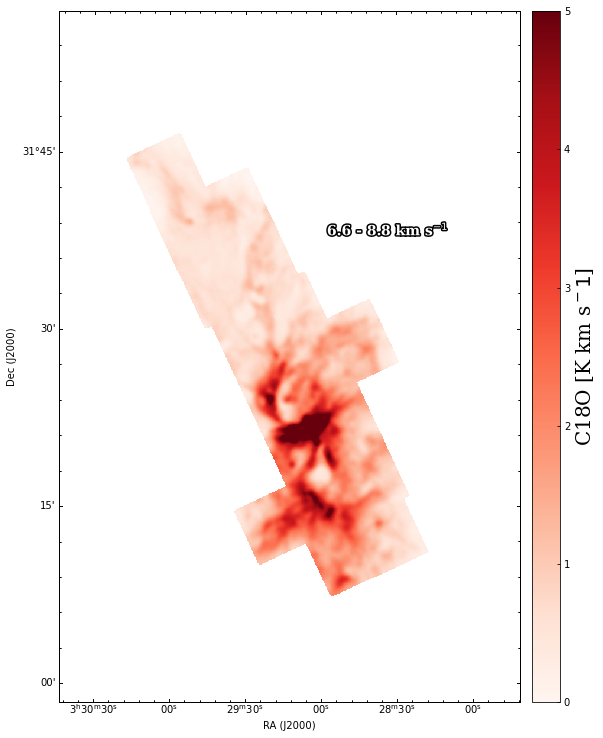

In [9]:
fits_name = filename
mapcenter_x, mapcenter_y, mapsize_x, mapsize_y = 52.3018836, 31.4612649, 0.65, 0.4 # identify map center position and mapsize in degree
color_min, color_max = 0, 5 # color range

v_start = 6.65
ch_range =  v2ch(v=8.7,w=w) - v2ch(v_start,w)
image_no = 3
desc="higher"

n, m = 1, 1 # number of columns, number of rows
figsize = (8, 12) # figure size
cmap = cm.Reds # colormap
stretch = "linear" # linear or log
cb_label = f"{species} [K km s$^{-1}$]" # colorbar label
save_name = func_chmap_integ_nxm(fits_name, v_start, ch_range, color_min, color_max, mapcenter_x, mapcenter_y, mapsize_x, mapsize_y, figsize, n, m, cmap, stretch, cb_label,image_no=image_no,desc=desc)

print(save_name)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


ch_s=256
1 / 1
ch_s=256, ch_e=302
pdf/NGC1333TP.C18O._v_0-1_cube_rms-5.29kms-46ch


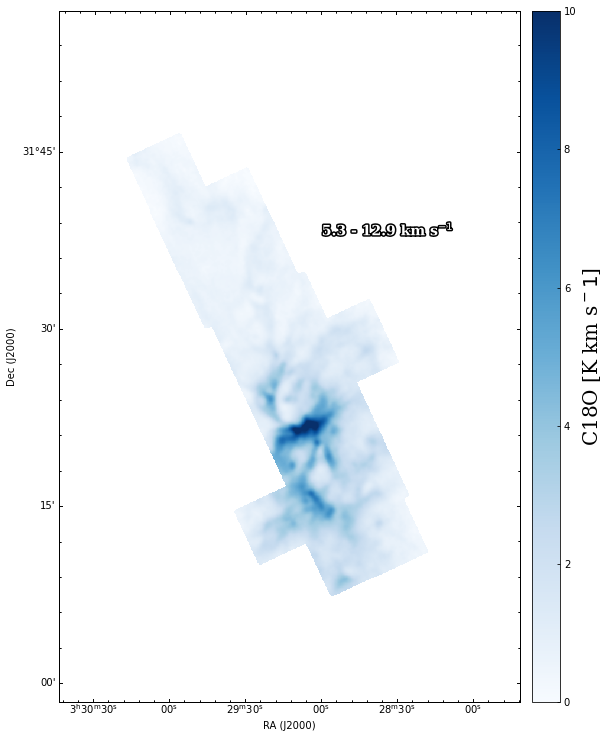

In [18]:
fits_name = filename
mapcenter_x, mapcenter_y, mapsize_x, mapsize_y = 52.3018836, 31.4612649, 0.65, 0.4 # identify map center position and mapsize in degree
ch_range = 2 # number of channels in 1 panel
color_min, color_max = 0, 10 # color range

v_start = 5.29
ch_range =  v2ch(v=12.96,w=w) - v2ch(v_start,w)


n, m = 1, 1 # number of columns, number of rows
figsize = (8,12) # figure size
cmap = cm.Blues # colormap
stretch = "linear" # linear or log
cb_label = f"{species} [K km s$^{-1}$]" # colorbar label
save_name = func_chmap_integ_nxm(fits_name, v_start, ch_range, color_min, color_max, mapcenter_x, mapcenter_y, mapsize_x, mapsize_y, figsize, n, m, cmap, stretch, cb_label, yso=False)

print(save_name)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


ch_s=103
1 / 36
ch_s=103, ch_e=108


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 36
ch_s=104, ch_e=109


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 36
ch_s=105, ch_e=110


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 36
ch_s=106, ch_e=111


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 36
ch_s=107, ch_e=112


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 36
ch_s=108, ch_e=113


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 36
ch_s=109, ch_e=114


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 36
ch_s=110, ch_e=115


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 36
ch_s=111, ch_e=116


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


10 / 36
ch_s=112, ch_e=117


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


11 / 36
ch_s=113, ch_e=118


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


12 / 36
ch_s=114, ch_e=119


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


13 / 36
ch_s=115, ch_e=120


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


14 / 36
ch_s=116, ch_e=121


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


15 / 36
ch_s=117, ch_e=122


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


16 / 36
ch_s=118, ch_e=123


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


17 / 36
ch_s=119, ch_e=124


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


18 / 36
ch_s=120, ch_e=125


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


19 / 36
ch_s=121, ch_e=126


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


20 / 36
ch_s=122, ch_e=127


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


21 / 36
ch_s=123, ch_e=128


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


22 / 36
ch_s=124, ch_e=129


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


23 / 36
ch_s=125, ch_e=130


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


24 / 36
ch_s=126, ch_e=131


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


25 / 36
ch_s=127, ch_e=132


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


26 / 36
ch_s=128, ch_e=133


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


27 / 36
ch_s=129, ch_e=134


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


28 / 36
ch_s=130, ch_e=135


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


29 / 36
ch_s=131, ch_e=136


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


30 / 36
ch_s=132, ch_e=137


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


31 / 36
ch_s=133, ch_e=138


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


32 / 36
ch_s=134, ch_e=139


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


33 / 36
ch_s=135, ch_e=140


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


34 / 36
ch_s=136, ch_e=141


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


35 / 36
ch_s=137, ch_e=142


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


36 / 36
ch_s=138, ch_e=143
pdf/NGC1333TP.N2D+.chmap_6.0_kms_chainc1.0_inc_kms_5ch_6x6


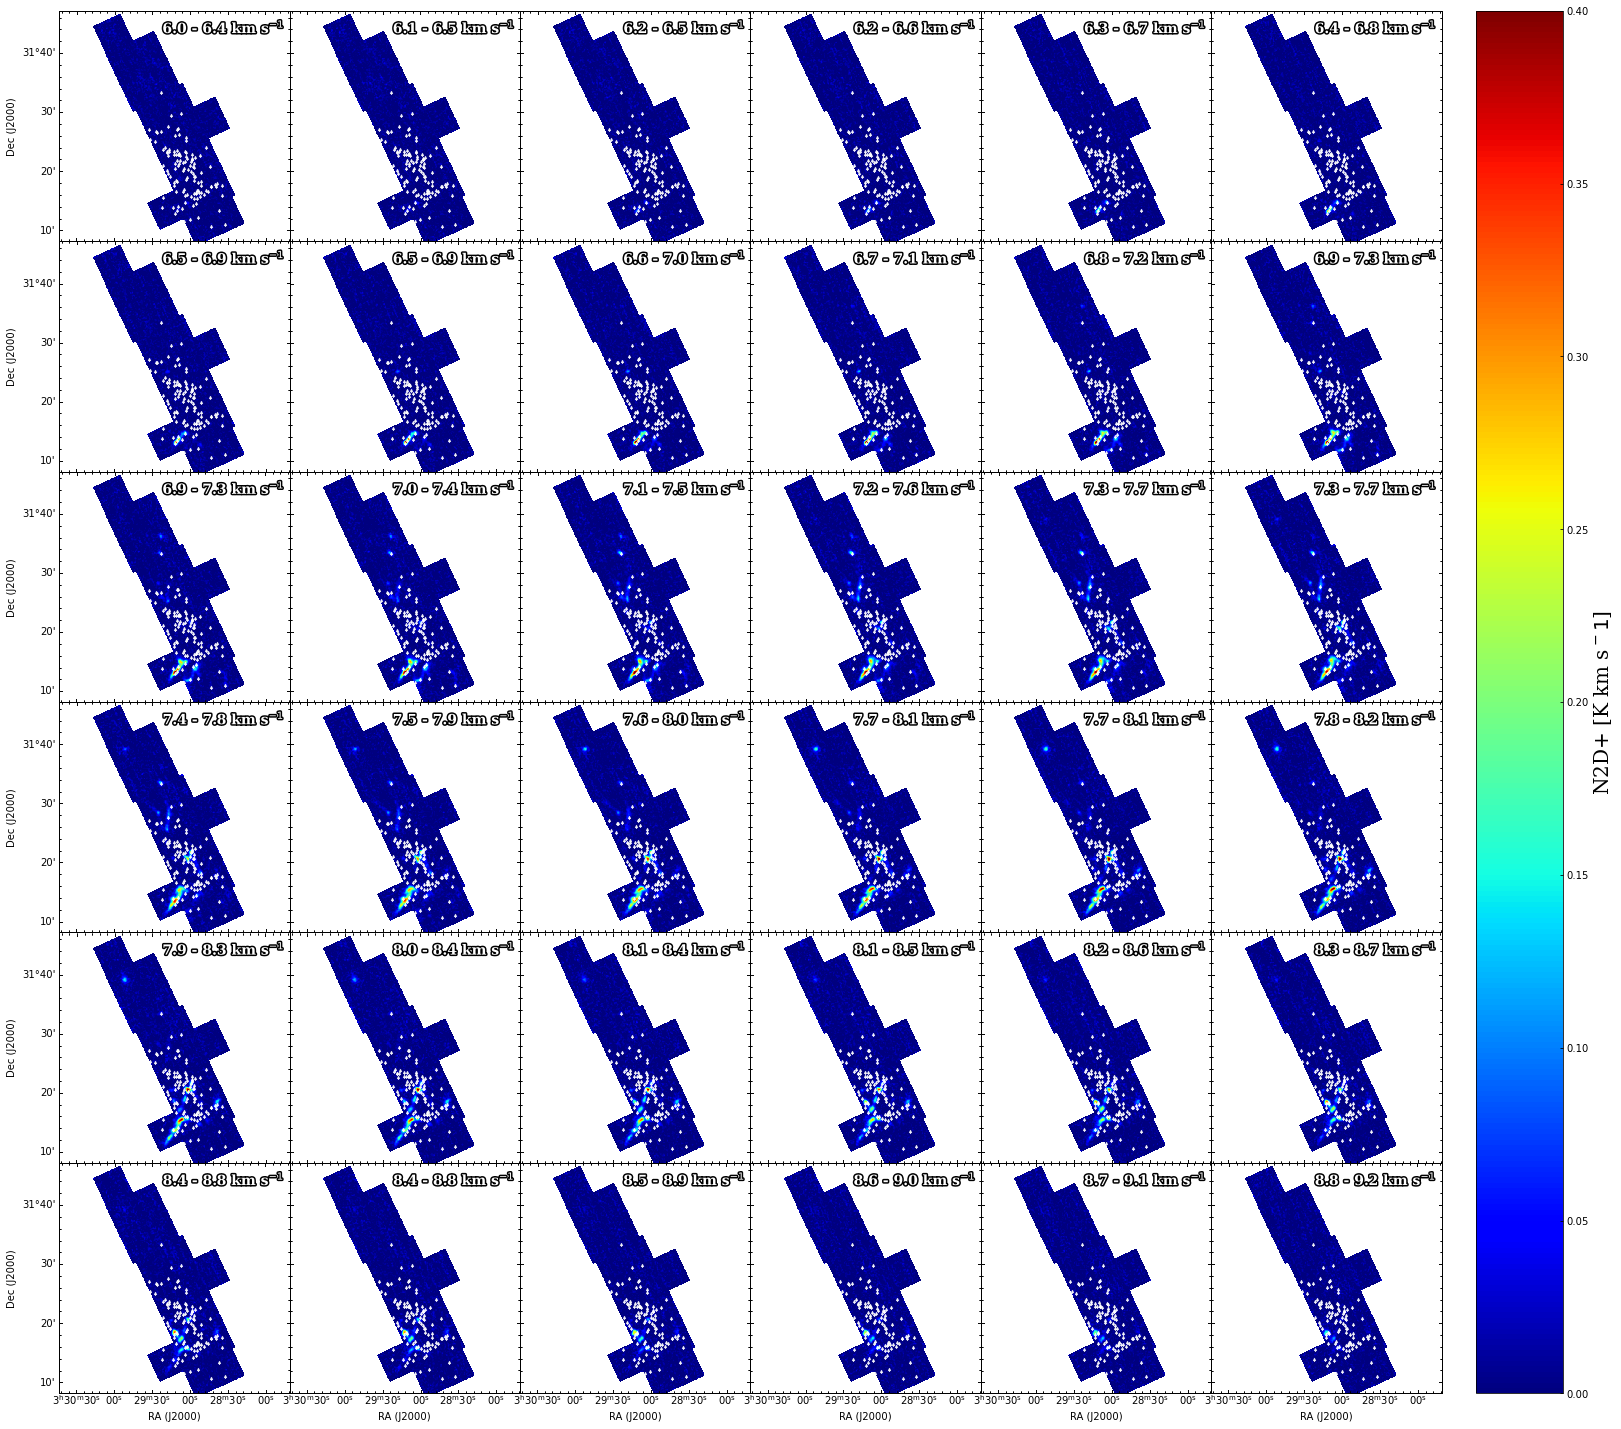

In [22]:
fits_name = filename
mapcenter_x, mapcenter_y, mapsize_x, mapsize_y = 52.3018836, 31.4612649, 0.65, 0.4 # identify map center position and mapsize in degree
v_start = 6 # identify start velocity position (km/s)
ch_range = 5 # number of channels in 1 panel
color_min, color_max = 0,0.4  # color range
n, m = 6, 6 # number of columns, number of rows
figsize = (n*4, m*4) # figure size
cmap = cm.jet # colormap
stretch = "linear" # linear or log
cb_label = f"{species} [K km s$^{-1}$]" # colorbar label
save_name = func_chmap_integ_increasing_startch_nxm(fits_name, v_start,1, ch_range, color_min, color_max, mapcenter_x, mapcenter_y, mapsize_x, mapsize_y, figsize, n, m, cmap, stretch, cb_label,yso=True)
print(save_name)

  0%|          | 0/11 [00:00<?, ?it/s]WARNING: FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60230.182229 from DATE-OBS'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


ch_s=265
1 / 9
ch_s=265, ch_e=267


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=267, ch_e=269


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=269, ch_e=271


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=271, ch_e=273


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=273, ch_e=275


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=275, ch_e=277


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=277, ch_e=279


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=279, ch_e=281


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=281, ch_e=283
Finished pdf/NGC1333TP.C18O.chmap_6.8_kms_2ch_3x3
ch_s=265


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1 / 9
ch_s=265, ch_e=268


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=268, ch_e=271


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=271, ch_e=274


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=274, ch_e=277


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=277, ch_e=280


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=280, ch_e=283


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=283, ch_e=286


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=286, ch_e=289


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=289, ch_e=292


  9%|▉         | 1/11 [01:47<17:51, 107.15s/it]

Finished pdf/NGC1333TP.C18O.chmap_6.8_kms_3ch_3x3
ch_s=266


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1 / 9
ch_s=266, ch_e=268


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=268, ch_e=270


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=270, ch_e=272


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=272, ch_e=274


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=274, ch_e=276


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=276, ch_e=278


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=278, ch_e=280


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=280, ch_e=282


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=282, ch_e=284
Finished pdf/NGC1333TP.C18O.chmap_7.0_kms_2ch_3x3
ch_s=266


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1 / 9
ch_s=266, ch_e=269


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=269, ch_e=272


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=272, ch_e=275


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=275, ch_e=278


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=278, ch_e=281


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=281, ch_e=284


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=284, ch_e=287


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=287, ch_e=290


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=290, ch_e=293


 18%|█▊        | 2/11 [03:32<15:55, 106.12s/it]

Finished pdf/NGC1333TP.C18O.chmap_7.0_kms_3ch_3x3
ch_s=268


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1 / 9
ch_s=268, ch_e=270


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=270, ch_e=272


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=272, ch_e=274


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=274, ch_e=276


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=276, ch_e=278


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=278, ch_e=280


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=280, ch_e=282


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=282, ch_e=284


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=284, ch_e=286
Finished pdf/NGC1333TP.C18O.chmap_7.2_kms_2ch_3x3
ch_s=268


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1 / 9
ch_s=268, ch_e=271


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=271, ch_e=274


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=274, ch_e=277


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=277, ch_e=280


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=280, ch_e=283


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=283, ch_e=286


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=286, ch_e=289


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=289, ch_e=292


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=292, ch_e=295


 27%|██▋       | 3/11 [05:15<13:57, 104.75s/it]

Finished pdf/NGC1333TP.C18O.chmap_7.2_kms_3ch_3x3
ch_s=269


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1 / 9
ch_s=269, ch_e=271


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=271, ch_e=273


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=273, ch_e=275


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=275, ch_e=277


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=277, ch_e=279


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=279, ch_e=281


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=281, ch_e=283


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=283, ch_e=285


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=285, ch_e=287
Finished pdf/NGC1333TP.C18O.chmap_7.4_kms_2ch_3x3
ch_s=269


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1 / 9
ch_s=269, ch_e=272


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=272, ch_e=275


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=275, ch_e=278


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=278, ch_e=281


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=281, ch_e=284


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=284, ch_e=287


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=287, ch_e=290


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=290, ch_e=293


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=293, ch_e=296


 36%|███▋      | 4/11 [06:59<12:09, 104.19s/it]

Finished pdf/NGC1333TP.C18O.chmap_7.4_kms_3ch_3x3
ch_s=270


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1 / 9
ch_s=270, ch_e=272


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=272, ch_e=274


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=274, ch_e=276


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=276, ch_e=278


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=278, ch_e=280


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=280, ch_e=282


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=282, ch_e=284


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=284, ch_e=286


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=286, ch_e=288
Finished pdf/NGC1333TP.C18O.chmap_7.6_kms_2ch_3x3
ch_s=270


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1 / 9
ch_s=270, ch_e=273


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=273, ch_e=276


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=276, ch_e=279


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=279, ch_e=282


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=282, ch_e=285


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=285, ch_e=288


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=288, ch_e=291


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=291, ch_e=294


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=294, ch_e=297


 45%|████▌     | 5/11 [08:44<10:27, 104.58s/it]

Finished pdf/NGC1333TP.C18O.chmap_7.6_kms_3ch_3x3
ch_s=271


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1 / 9
ch_s=271, ch_e=273


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=273, ch_e=275


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=275, ch_e=277


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=277, ch_e=279


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=279, ch_e=281


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=281, ch_e=283


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=283, ch_e=285


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=285, ch_e=287


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=287, ch_e=289
Finished pdf/NGC1333TP.C18O.chmap_7.8_kms_2ch_3x3
ch_s=271


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1 / 9
ch_s=271, ch_e=274


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2 / 9
ch_s=274, ch_e=277


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3 / 9
ch_s=277, ch_e=280


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4 / 9
ch_s=280, ch_e=283


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5 / 9
ch_s=283, ch_e=286


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6 / 9
ch_s=286, ch_e=289


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7 / 9
ch_s=289, ch_e=292


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


8 / 9
ch_s=292, ch_e=295


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


9 / 9
ch_s=295, ch_e=298


 45%|████▌     | 5/11 [10:27<12:33, 125.51s/it]


KeyboardInterrupt: 

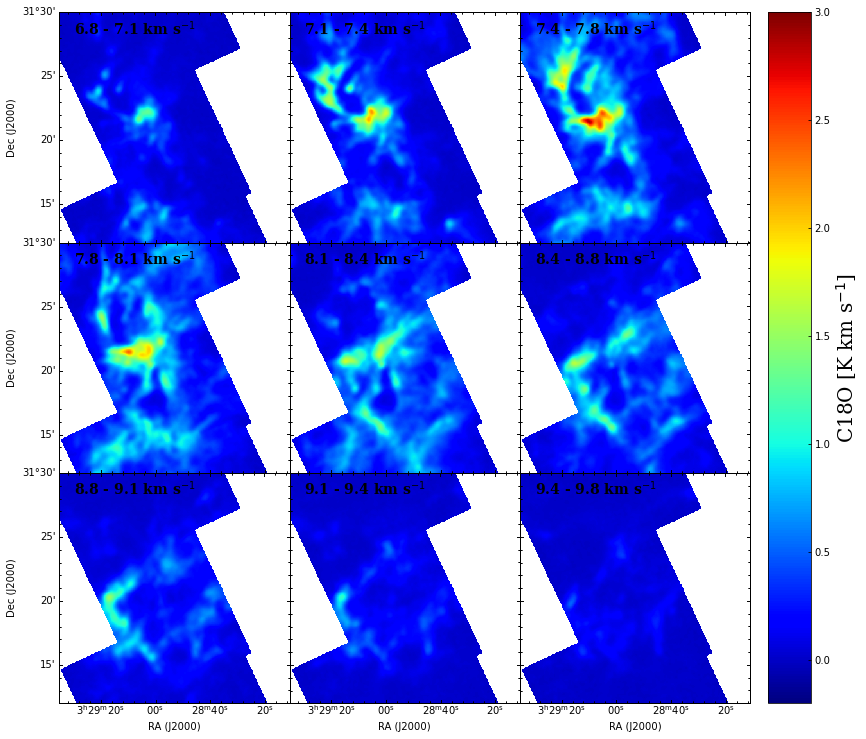

In [13]:
def consecutive_chan_maps(velocities,chans):
    for i in tqdm(velocities):
        for j in chans:
            save_name = func_chmap_integ_nxm(fits_name, i, j, color_min, color_max, mapcenter_x, mapcenter_y, mapsize_x, mapsize_y, figsize, n, m, cmap, stretch, cb_label)
            print(f"Finished {save_name}")
            
            
            
fits_name = filename
velocities = np.arange(start=6.8,stop=9,step=0.2)
chans = [2,3]


#consecutive_chan_maps(velocities,chans)

In [2]:
for i in range(2):
    print(i)

0
1
